<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [2]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [3]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [4]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [5]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



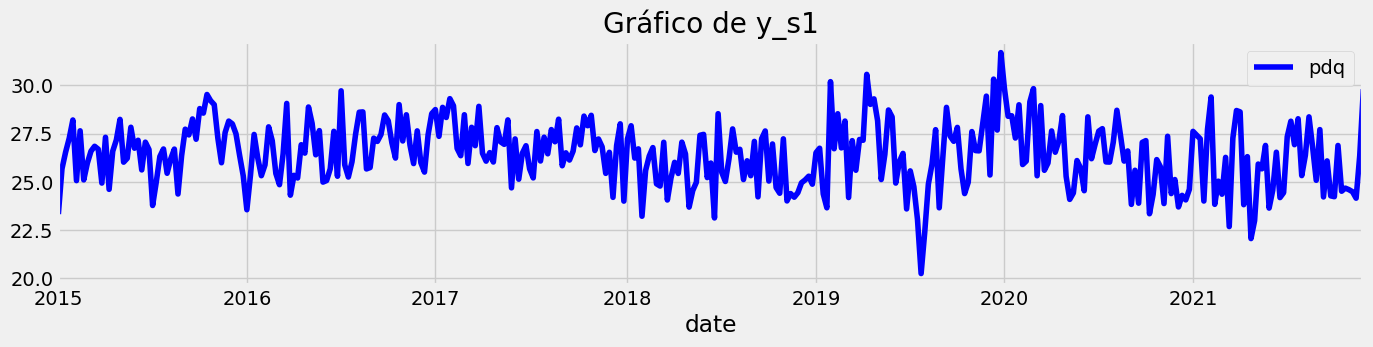

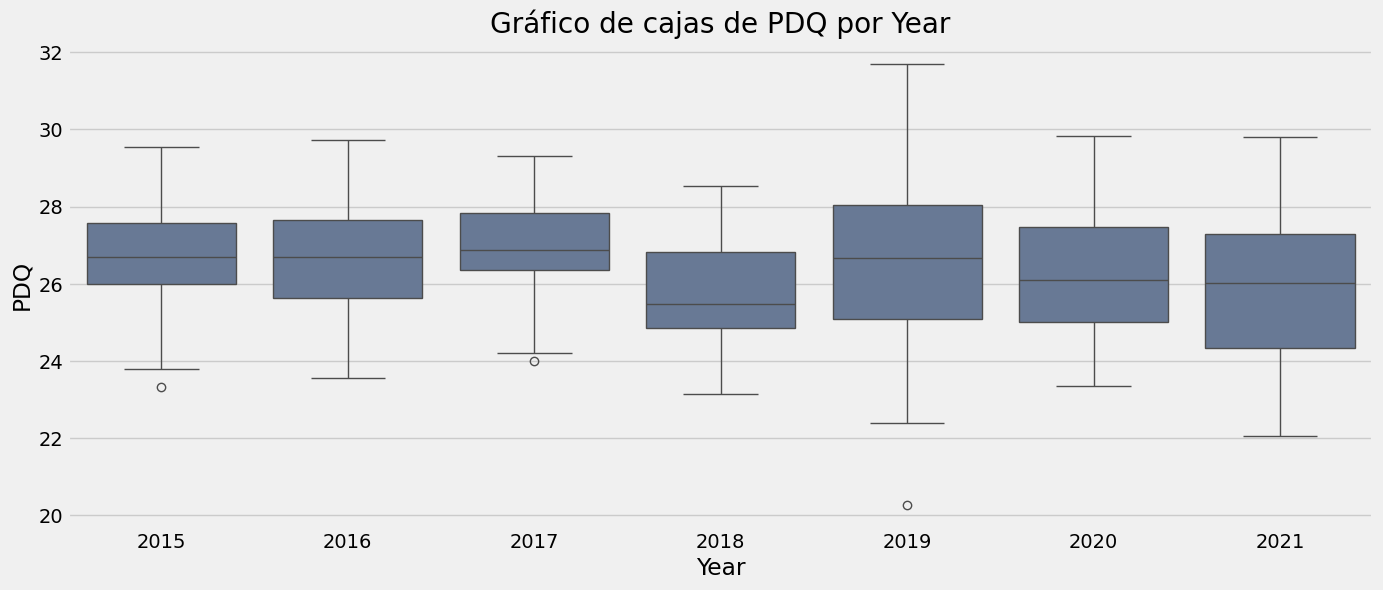

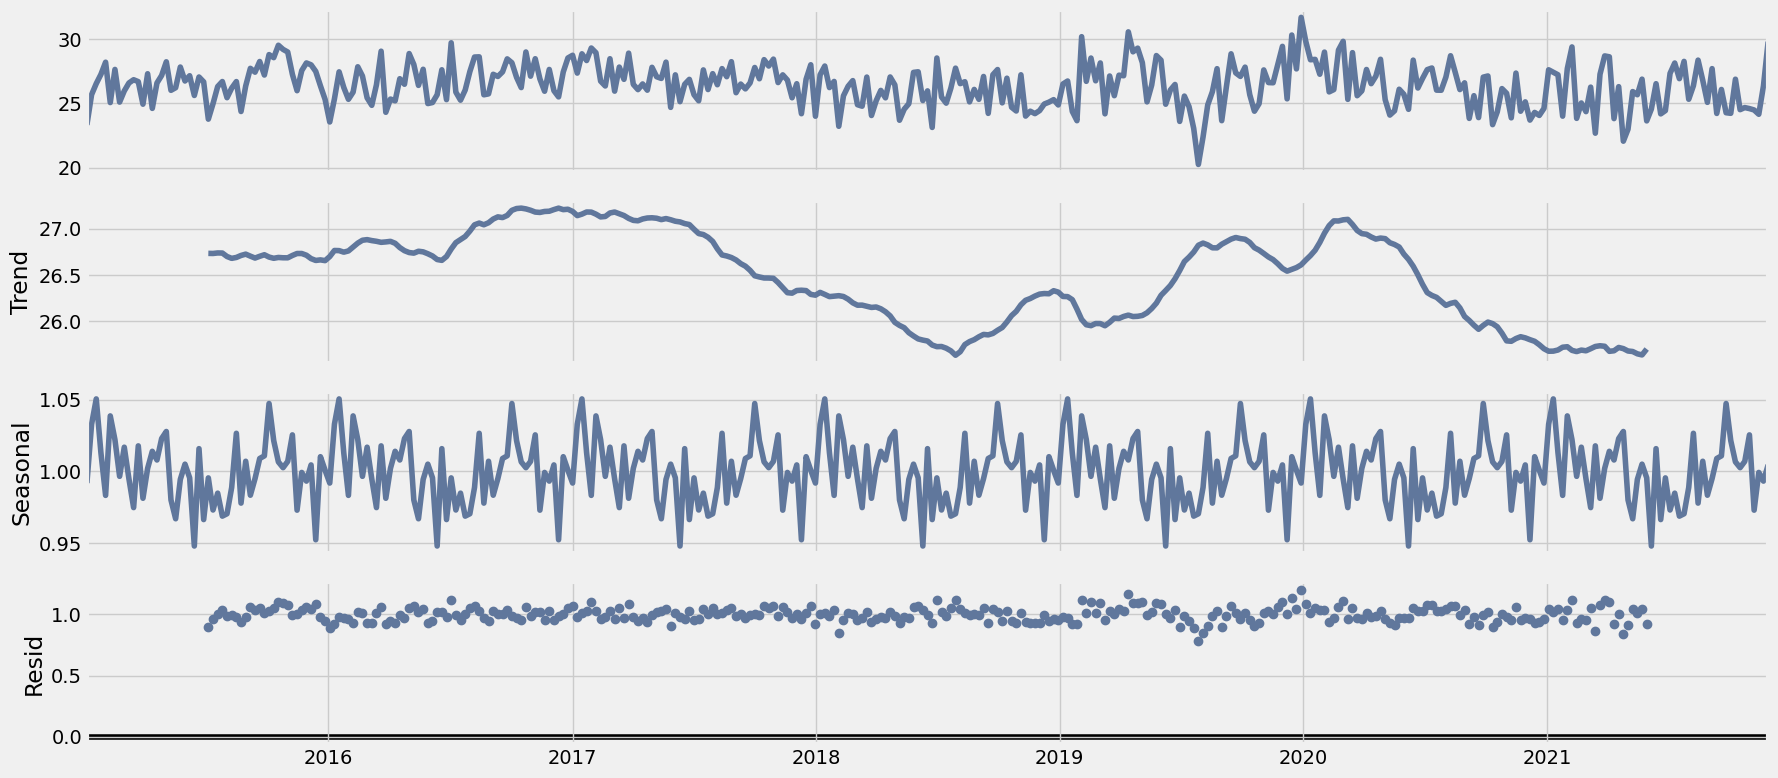

In [6]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

# graficar datos y_s1
y_s1.plot(figsize=(15, 3),color = 'blue')
plt.title("Gráfico de y_s1")
plt.show()

# Create the boxplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s1.index.year, y=y_s1["pdq"], data=y_s1, ax=ax)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Gráfico de cajas de PDQ por Year")

# Display the plot
plt.show()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s1, model='multiplicative')
fig = decomposition.plot()
plt.show()

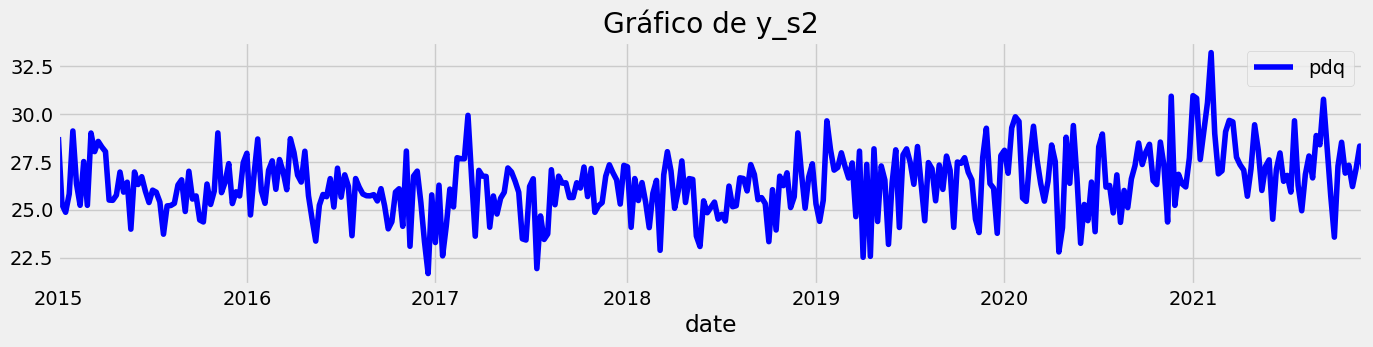

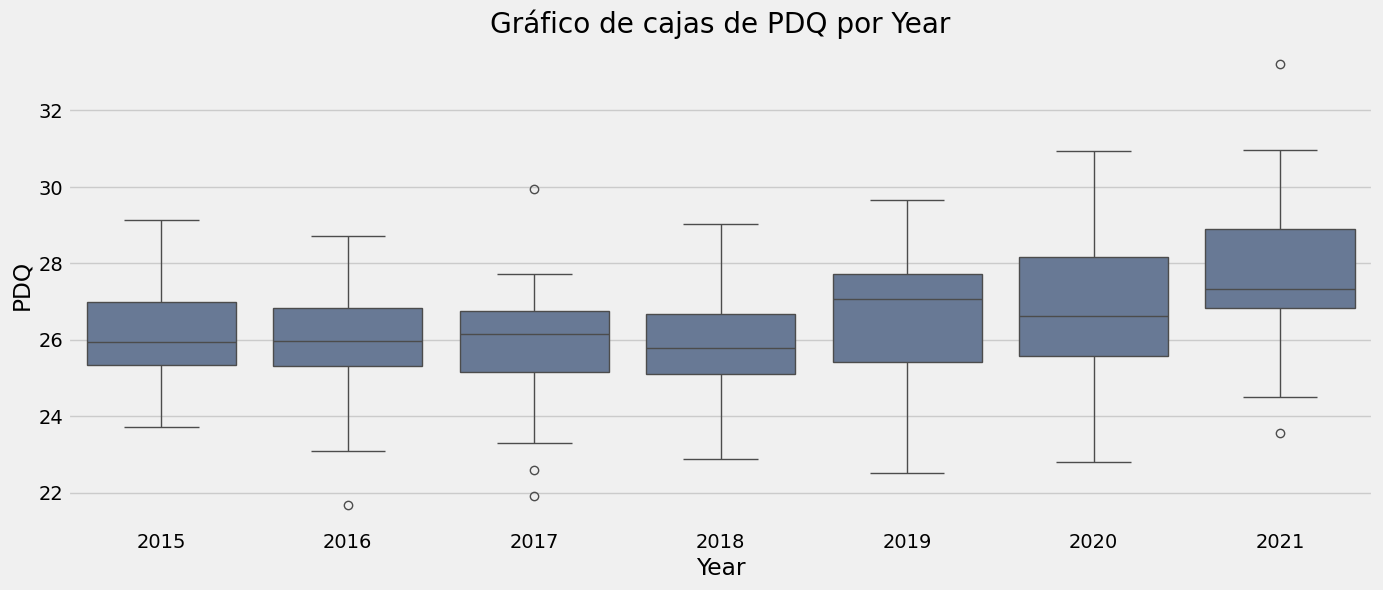

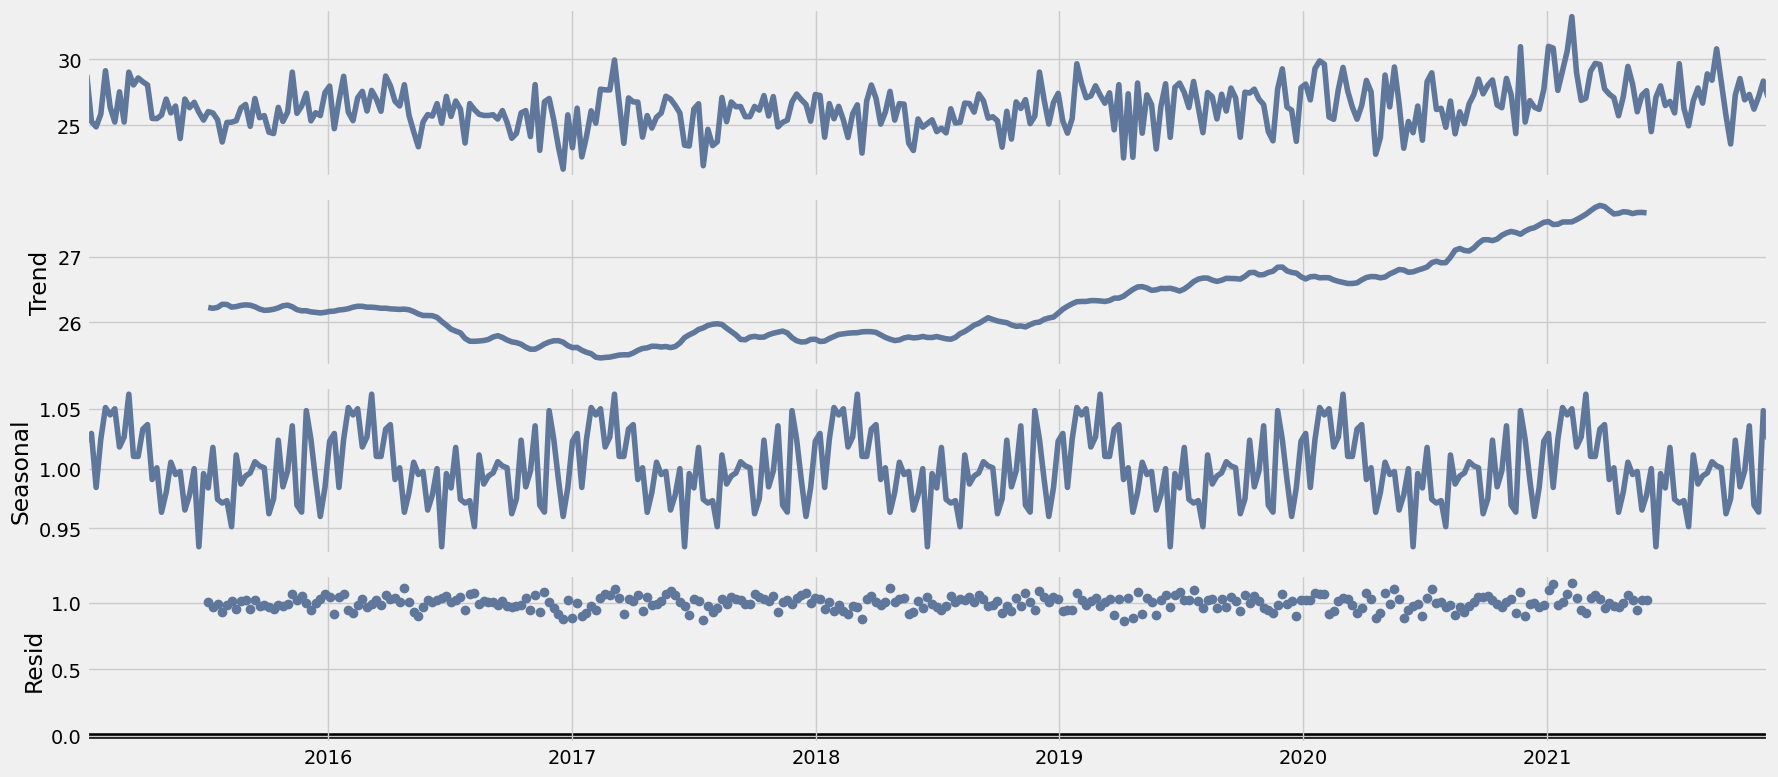

In [7]:
# graficar datos y_s2
y_s2.plot(figsize=(15, 3),color = 'blue')
plt.title("Gráfico de y_s2")
plt.show()

# Create the boxplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s2.index.year, y=y_s2["pdq"], data=y_s2, ax=ax)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Gráfico de cajas de PDQ por Year")

# Display the plot
plt.show()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s2, model='multiplicative')
fig = decomposition.plot()
plt.show()

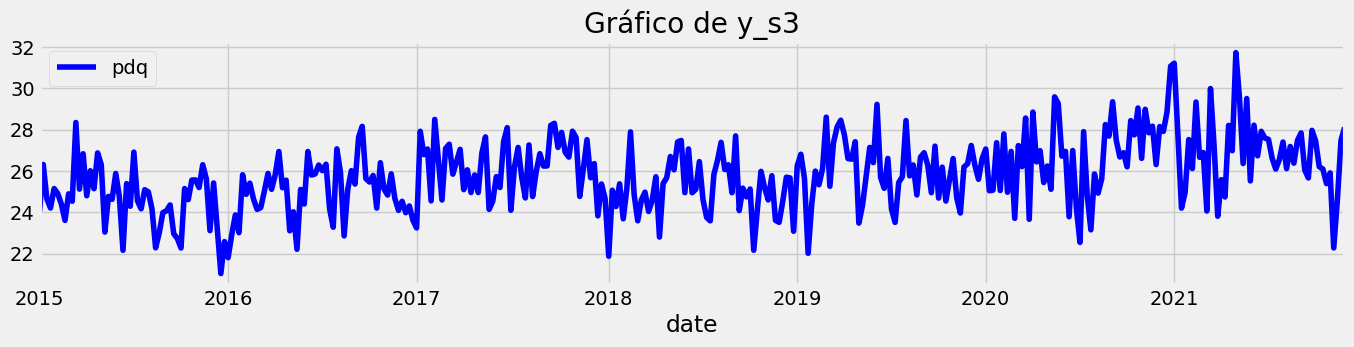

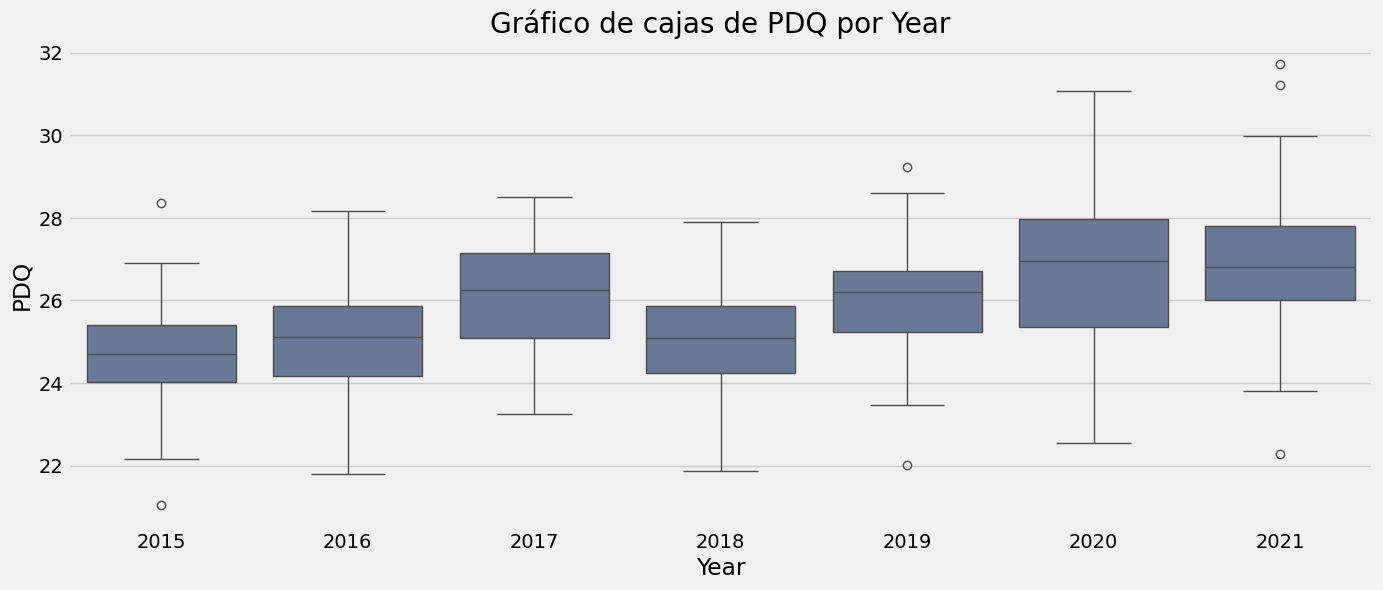

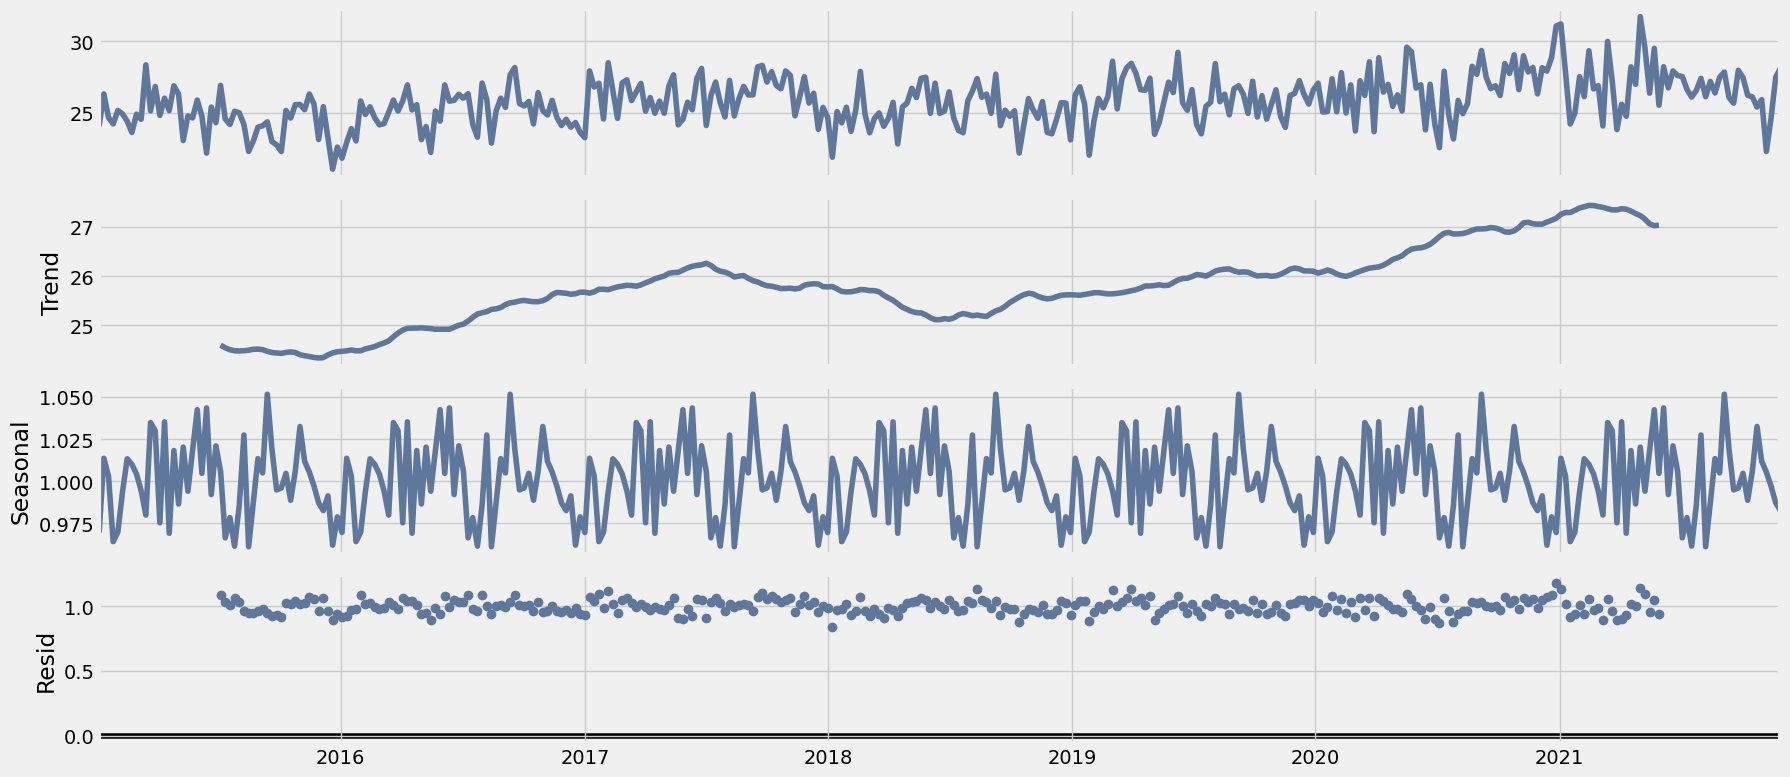

In [8]:
# graficar datos y_s3
y_s3.plot(figsize=(15, 3),color = 'blue')
plt.title("Gráfico de y_s3")
plt.show()

# Create the boxplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s3.index.year, y=y_s3["pdq"], data=y_s3, ax=ax)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Gráfico de cajas de PDQ por Year")

# Display the plot
plt.show()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s3, model='multiplicative')
fig = decomposition.plot()
plt.show()

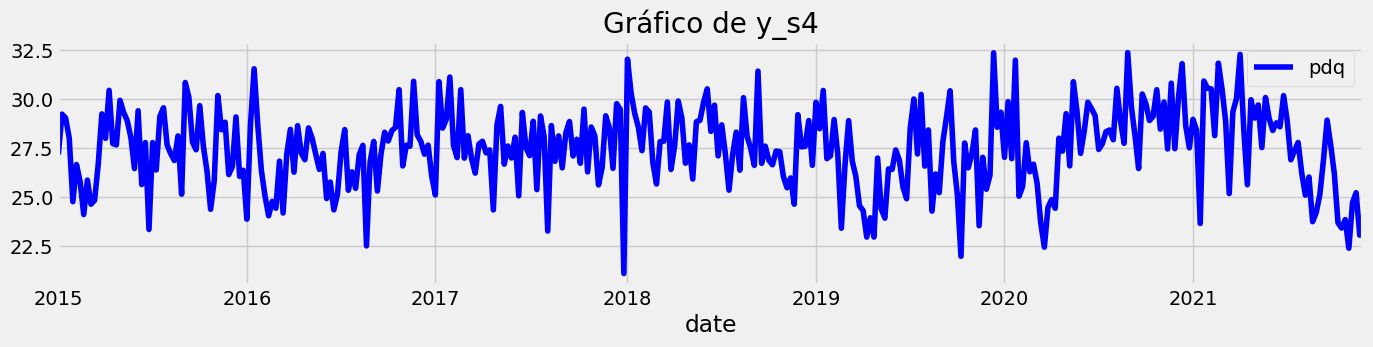

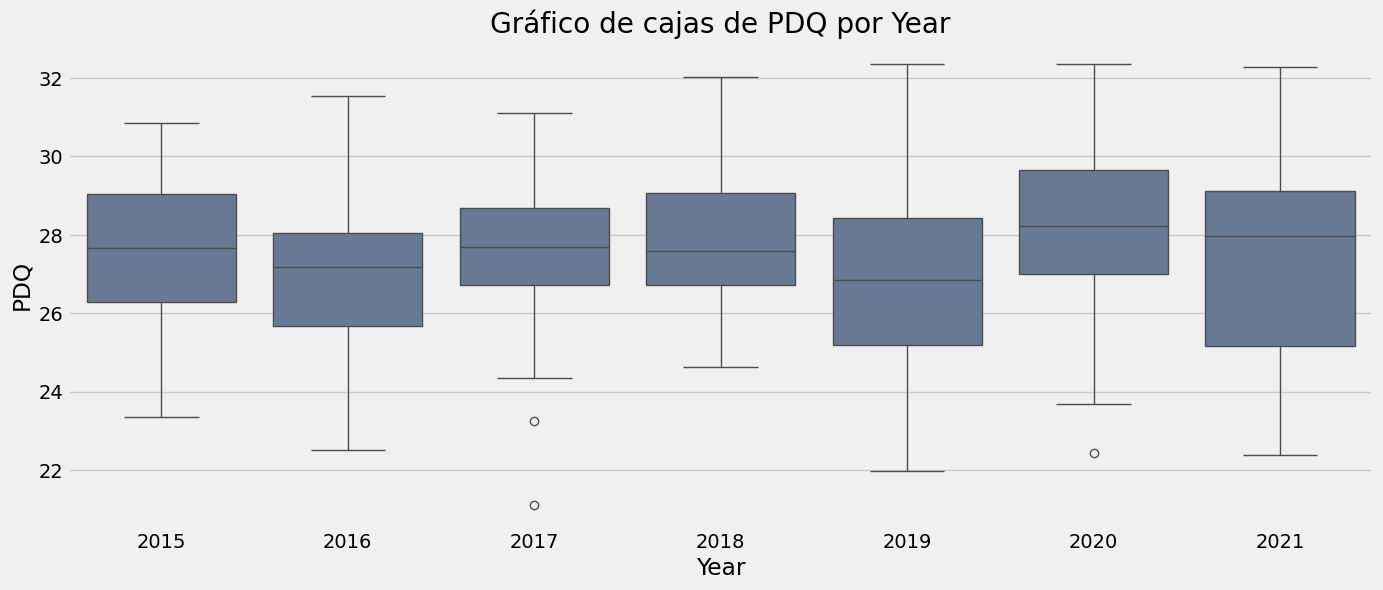

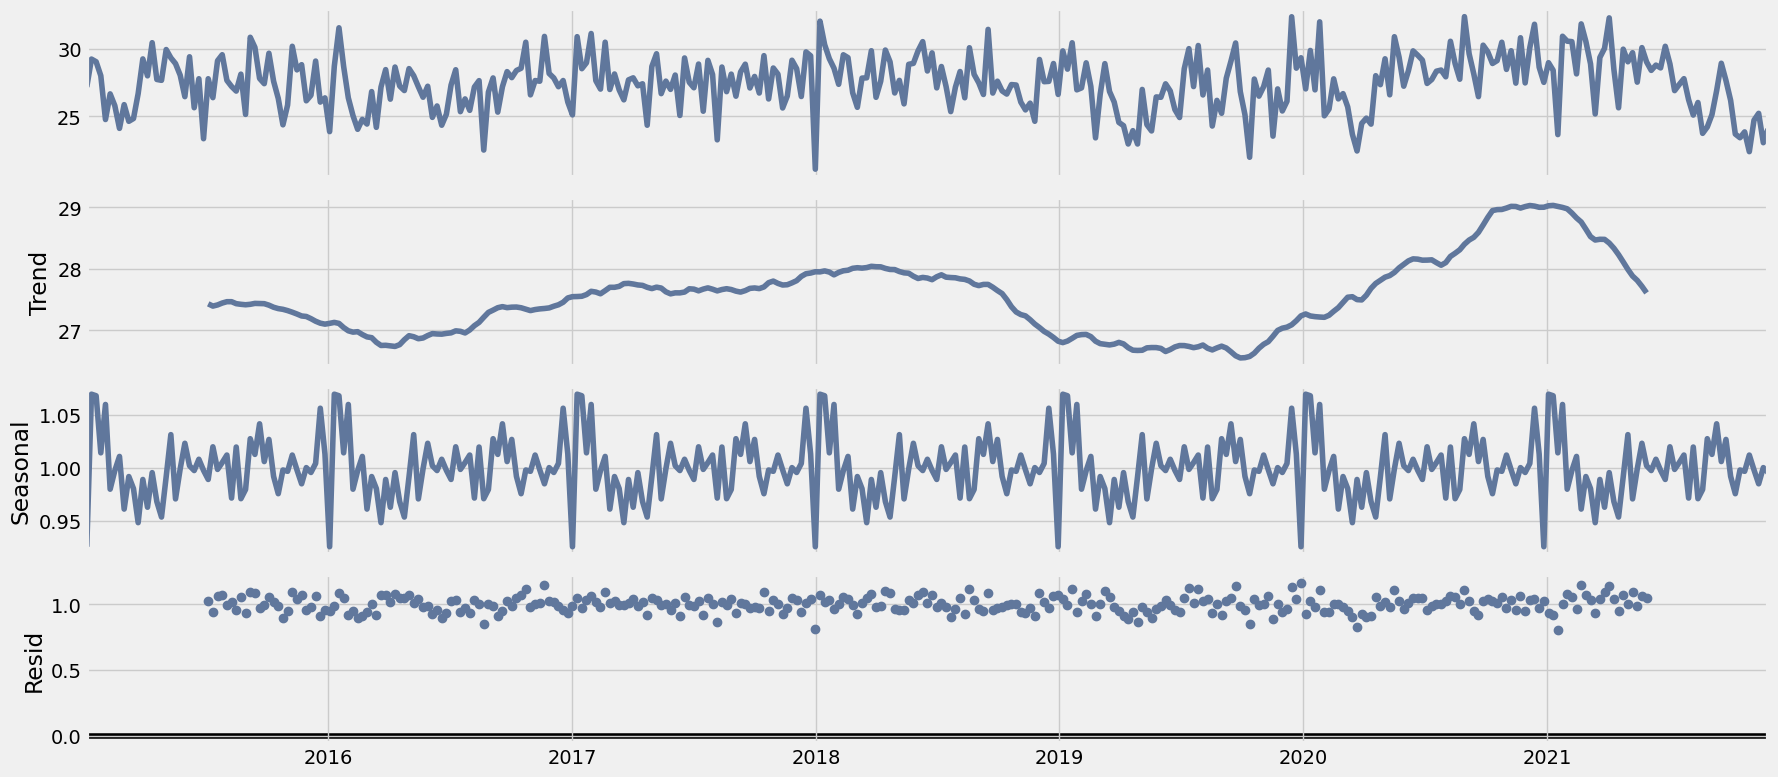

In [9]:
# graficar datos y_s4
y_s4.plot(figsize=(15, 3),color = 'blue')
plt.title("Gráfico de y_s4")
plt.show()

# Create the boxplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y_s4.index.year, y=y_s4["pdq"], data=y_s4, ax=ax)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("PDQ")
plt.title("Gráfico de cajas de PDQ por Year")

# Display the plot
plt.show()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s4, model='multiplicative')
fig = decomposition.plot()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [10]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

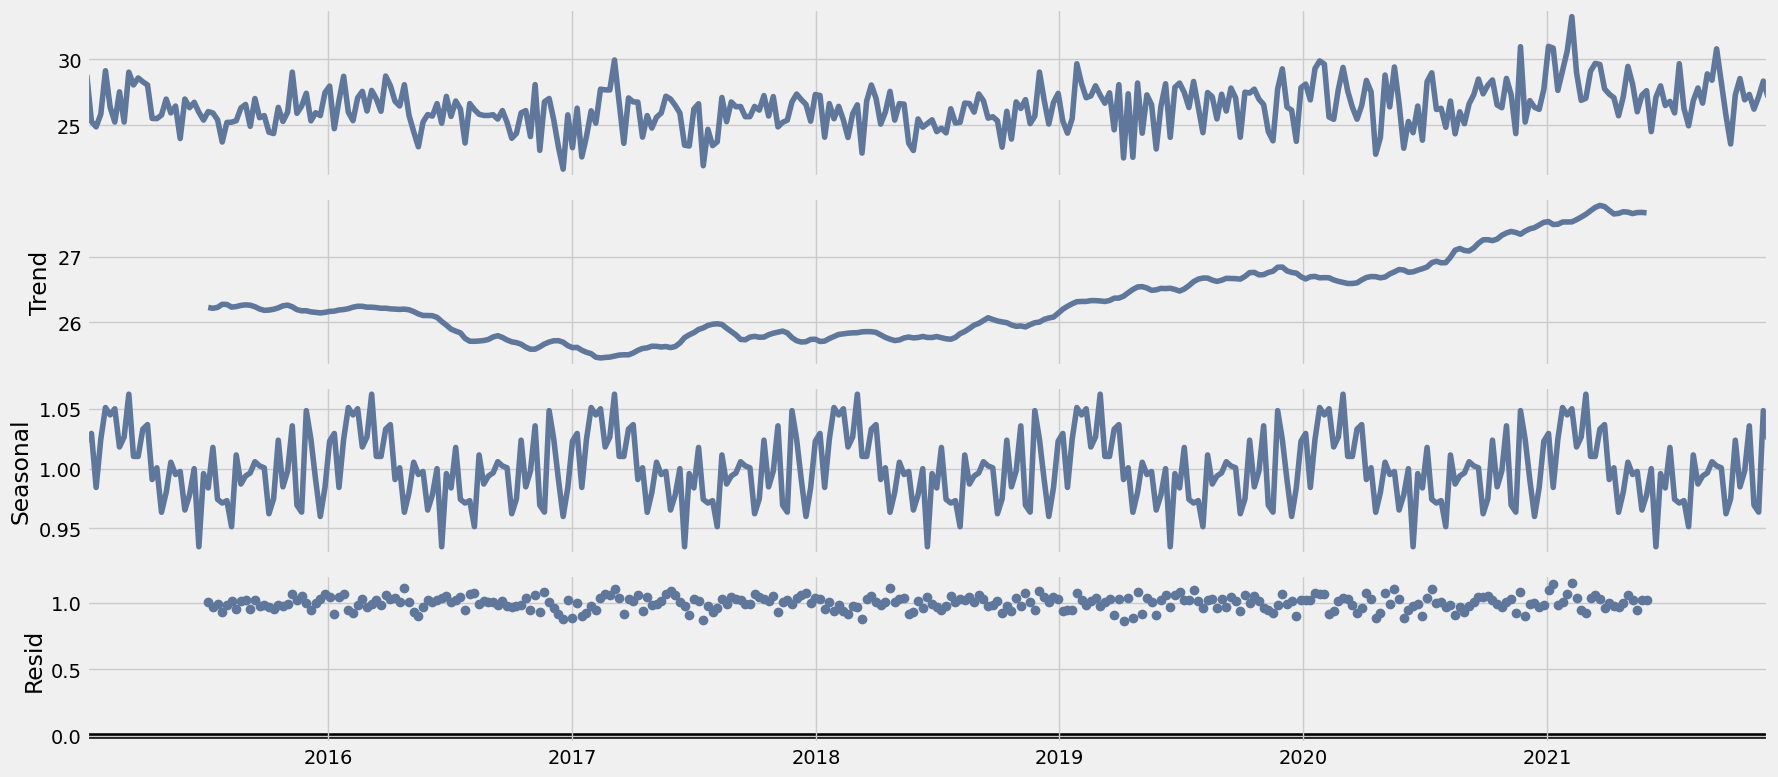

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s2, model='multiplicative')
fig = decomposition.plot()
plt.show()

En la tendencia se aprecia un descenso suave hasta 2017, una meseta entre 2017 y 2018 y, desde 2019, un alza marcada que se intensifica en 2020–2021. Esto sugiere que la media no es estacionaria y que hay un posible quiebre estructural cerca de 2019.
El componente estacional se mantiene estable y presenta un perfil “serrado” con ciclos breves y frecuentes, compatible con periodicidad intraanual (p. ej., semanal o mensual).

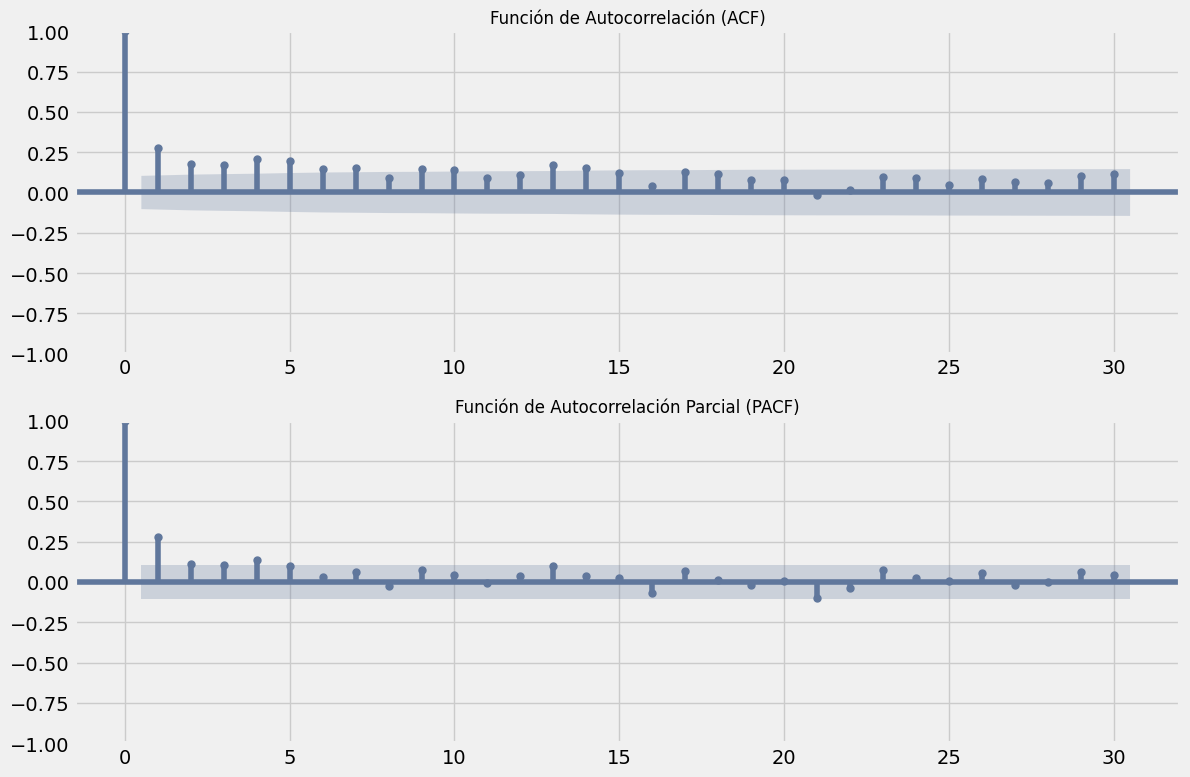

In [12]:
# Gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(12, 8))

# ACF
plt.subplot(2, 1, 1)
plot_acf(y_s2['pdq'], lags=30, ax=plt.gca())
plt.title("Función de Autocorrelación (ACF)", fontsize=12)

# PACF
plt.subplot(2, 1, 2)
plot_pacf(y_s2['pdq'], lags=30, ax=plt.gca())
plt.title("Función de Autocorrelación Parcial (PACF)", fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# Prueba de Dickey-Fuller para verificar estacionariedad
from statsmodels.tsa.stattools import adfuller
import pandas as pd

print("📊 Resultados de la prueba de Dickey-Fuller:")

# Ejecutar el test
resultado = adfuller(y_s2['pdq'], autolag='AIC')

# Organizar resultados principales
df_output = pd.Series(resultado[0:4],
                      index=['Estadístico de prueba', 'Valor p', '# de retardos usados', 'Número de observaciones'])

# Mostrar resultados
print(df_output)

# Interpretación rápida
if resultado[1] <= 0.05:
    print("\n✅ Se rechaza la hipótesis nula: la serie es estacionaria.")
else:
    print("\n❌ No se rechaza la hipótesis nula: la serie no es estacionaria.")


📊 Resultados de la prueba de Dickey-Fuller:
Estadístico de prueba       -5.434942
Valor p                      0.000003
# de retardos usados         4.000000
Número de observaciones    356.000000
dtype: float64

✅ Se rechaza la hipótesis nula: la serie es estacionaria.


## Sarima

In [14]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s2,target_date)
        frames.append(df_metrics)
    except:
        pass
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

C:\Users\William\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.3551,3.4263,1.8510,0.0478,0.0476,0.0488,0.0461,0.0486,"SARIMA_(1,1,0)X(1,0,1,12)"
0,1.3567,3.4359,1.8536,0.0478,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(0,0,1,12)"
0,1.3584,3.4565,1.8592,0.0479,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(1,0,0,12)"
0,1.3588,3.5038,1.8718,0.0478,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(0,0,0,12)"
0,1.3703,3.1981,1.7883,0.0491,0.0490,0.0494,0.0474,0.0492,"SARIMA_(0,1,0)X(0,0,0,12)"
...,...,...,...,...,...,...,...,...,...
0,3.1468,13.4226,3.6637,0.1107,0.1098,0.1133,0.1069,0.1192,"SARIMA_(1,1,0)X(1,1,0,12)"
0,24.1010,618.8685,24.8771,0.8744,0.7022,0.8681,0.8436,1.6744,"SARIMA_(0,0,0)X(0,0,1,12)"
0,24.5214,625.0162,25.0003,0.8893,0.7163,0.8833,0.8581,1.6908,"SARIMA_(0,0,1)X(0,0,1,12)"
0,27.5504,762.9708,27.6219,0.9932,0.7814,0.9924,0.9585,1.9794,"SARIMA_(0,0,1)X(0,0,0,12)"


El modelo SARIMA (1,1,0) x (1,0,1,12) es el mejor rendimiento, ya que obtine los menores valores de MAE y MAPE. En particular MAE= 1.3551 significa que, en promedio, las predicciones se apartan 1.3551 unidades de los datos observados, mientras que MAPE = 0.0478 indica un error medio cercano al 4.78% respecto del valor real.

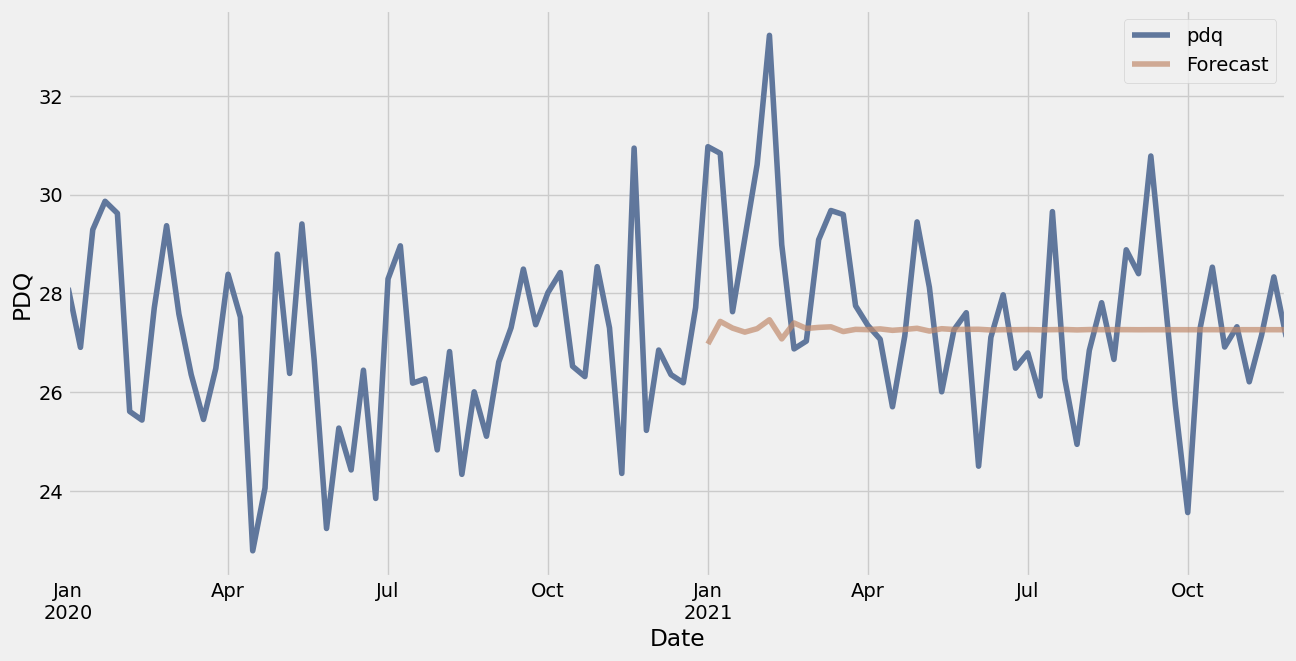

In [15]:
# Ajustar mejor modelo (manteniendo tu interfaz)

param = [(1,1,0),(1,0,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s2,target_date)
best_model = sarima_model.df_testig(y_s2,target_date)
best_model.head()

# Graficar el mejor modelo

# Se extraen las predicciones del modelo ajustado
preds = best_model['yhat']

# Se grafica la serie original desde 2020 en adelante
ax = y_s2["2020":].plot(label='observed')

# Se superponen las predicciones sobre la misma figura
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

# Se agregan etiquetas a los ejes
ax.set_xlabel('Date')
ax.set_ylabel('PDQ')

# Se muestra la leyenda y el gráfico final
plt.legend()
plt.show()

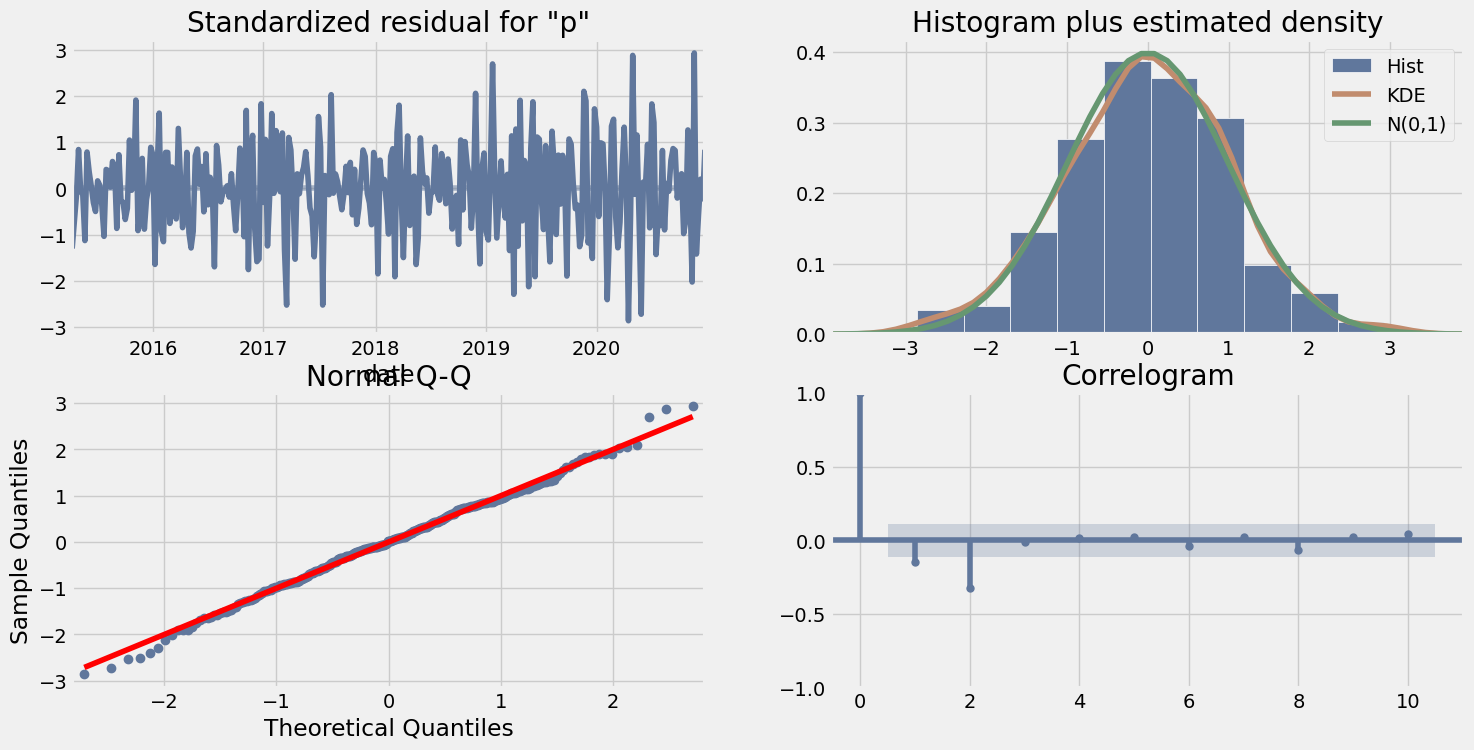

In [16]:
# Validación del modelo
# La función plot_diagnostics muestra cuatro gráficos que permiten analizar los residuales
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

En el gráfico temporal de los errores no se aprecia estructura: oscilan en torno a 0 sin tendencia ni patrón identificable. En el histograma, la densidad estimada (KDE) prácticamente coincide con la curva de 𝑁(0,1). En el Q–Q, la mayoría de los puntos se alinea con la recta de referencia, lo que respalda la normalidad de los residuos. En suma, los residuos del modelo elegido, aun tratándose de un modelo solo con término constante, se comportan como ruido blanco (media cercana a cero, varianza aproximadamente estable y sin autocorrelación evidente).




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [21]:
from prophet import Prophet

# Crear conjuntos de entrenamiento y prueba
y_train = y_s2.loc[y_s2.index < target_date]
y_test  = y_s2.loc[y_s2.index >= target_date]

# rename
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]

# model
m = Prophet()
m.fit(y_train_prophet)

# forecast
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)[['ds', 'yhat']]
forecast.tail()

23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
1768,2024-12-22,28.216955
1769,2024-12-23,28.230616
1770,2024-12-24,28.252204
1771,2024-12-25,28.281121
1772,2024-12-26,28.316625


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# metrics
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el error porcentual absoluto medio (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def regression_metrics(df):
    """
    Calcula métricas de evaluación para modelos de series temporales o regresión.

    Parámetros:
        df (pd.DataFrame): DataFrame con columnas ['y', 'yhat'] donde:
            - 'y'    : valores reales
            - 'yhat' : valores predichos

    Retorna:
        pd.DataFrame: tabla con las métricas MAE, MSE, RMSE, MAPE y sMAPE
    """
    y_true = df['y']
    y_pred = df['yhat']

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = 2 * mape / (mape + 100)

    df_result = pd.DataFrame({
        'MAE': [round(mae, 4)],
        'MSE': [round(mse, 4)],
        'RMSE': [round(rmse, 4)],
        'MAPE': [round(mape, 4)],
        'sMAPE': [round(smape, 4)]
    })

    return df_result

result = y_test_prophet.merge(forecast,on = 'ds',how='inner')
regression_metrics(result)

,MAE,MSE,RMSE,MAPE,sMAPE
0,1.2731,2.9623,1.7211,4.4692,0.0856


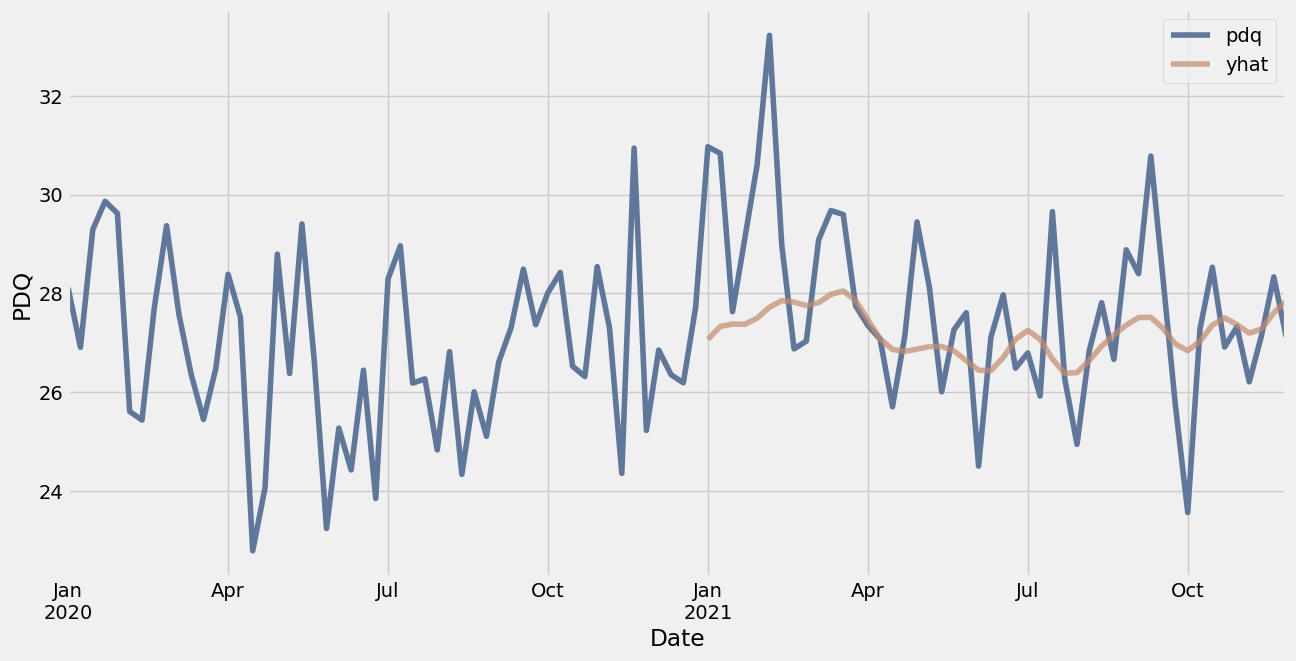

In [22]:
# Graficar las predicciones del modelo Prophet frente a los valores reales

# Se preparan las predicciones con el índice de fechas
preds = result[['ds', 'yhat']].set_index("ds")

# Serie observada y pronosticada
ax = y_s2['2020':].plot(label='Observed', figsize=(14, 7))
preds.plot(ax=ax, label='Forecast', alpha=0.7)

# Detalles del gráfico
ax.set_xlabel('Date')
ax.set_ylabel('PDQ')
plt.legend()
plt.show()


In [23]:
pd1 = df_metrics_result[df_metrics_result["model"]=="SARIMA_(1,1,0)X(1,0,1,12)"]
pd2 = regression_metrics(result)

# Renombrar columnas en pd2 para que coincidan con pd1
pd2_renamed = pd2.rename(columns={
    'MAE': 'mae',
    'MSE': 'mse',
    'RMSE': 'rmse',
    'MAPE': 'mape',
    'sMAPE': 'smape'
})

# Agregar una columna 'model' a pd2_renamed para identificar el modelo
pd2_renamed['model'] = 'Prophet'
pd2_renamed["mape"]/=100

# Concatenar los dos dataframes
combined_metrics = pd.concat([pd1, pd2_renamed], ignore_index=True).drop(["maape","wmape","mmape"], axis=1)

# Mostrar la tabla combinada
display(combined_metrics)

,mae,mse,rmse,mape,smape,model
0,1.3551,3.4263,1.8510,0.047800,0.0486,"SARIMA_(1,1,0)X(1,0,1,12)"
1,1.2731,2.9623,1.7211,0.044692,0.0856,Prophet


## Requisitos del modelo.



SARIMA asume estacionariedad en media y varianza. Si no se cumple, se recurre a diferenciar con d=1 y sin deriva, los pronósticos a varios pasos tienden a aplanarse. Prophet, por su parte, describe la señal con una tendencia por tramos y estacionalidades suaves, sin exigir estacionariedad, por lo que se adapta bien a cambios de pendiente.

Implementación.
SARIMA implica escoger (𝑝,𝑑,𝑞)×(𝑃,𝐷,𝑄,𝑆), evaluar transformaciones (p. ej., Box–Cox) o diferencias y verificar con diagnósticos; requiere más trabajo manual e inferencia, pero brinda mayor control. Prophet ofrece una interfaz sencilla y detecta automáticamente puntos de quiebre (changepoints), lo que facilita su puesta en marcha.

Aplicación a esta serie.
Como la serie exhibe estacionalidad débil multiplicativa y un quiebre de tendencia alrededor de 2019, SARIMA rindió bien a un paso, pero entregó trayectorias planas a horizontes más largos. Prophet captó el quiebre mediante changepoints y produjo proyecciones más verosímiles, lo que explica su mejor desempeño.

## Conclusiones

Prophet suele ser la opción más adecuada cuando hay quiebres de tendencia, estacionalidades suaves o de carácter multiplicativo, o cuando se requiere un despliegue rápido con buenas decisiones por defecto.

En cambio, SARIMA resulta más conveniente si, tras aplicar una transformación (p. ej., Box–Cox) o diferenciar, la serie queda aproximadamente estacionaria en media y varianza, o cuando se desea trabajar con un marco clásico de inferencia estadística (tests de hipótesis, criterios AIC/BIC) y mantener un mayor control sobre la especificación del modelo.